In [1]:
import numpy as np 
import pandas as pd 
import cv2
from matplotlib import pyplot as plt
import sys
import struct
import os
import functools
import math



def showImage(img):
    plt.figure(figsize=(15,15))
    plt.imshow(np.uint8(img),cmap='gray')
    plt.xticks([]),plt.yticks([])
    plt.show()
    

def zigZag(matrix):
    list = []

    rows= len(matrix)
    columns= len(matrix[0])
    
    solution=[[] for i in range(rows+columns-1)] 

    for i in range(rows): 
        for j in range(columns): 
            sum=i+j 
            if(sum%2 ==0): 

                #add at beginning 
                solution[sum].insert(0,matrix[i][j]) 
            else: 

                #add at end of the list 
                solution[sum].append(matrix[i][j]) 

    for i in solution: 
        for j in i: 
            list.append(j);

    return list


#Only for even squared Matrices
def reverseZigZag(list):
    n = int(math.sqrt(len(list)))
    matrix=[[0 for x in range(n)] for i in range(n)]
    k=0
    i=0
    j=0
    for k in range(0, len(list),1):
        change = False
        matrix[i][j] = list[k]
        if((i+j)%2 == 0):
            if(j < n-1):
                change = True
                j+=1
                if(i > 0):
                    i-=1        
            if(change == False):
                i+=1
        elif((i+j)%2 == 1):
            if(i<n-1):
                change = True
                i+=1
                if(j>0):
                    j-=1
            if(change ==  False):
                j+=1
    return matrix

In [2]:
class Node:
    def __init__(self, value, left, right):
        self.value = value
        self.left = left
        self.right = right
   
    def getLeft(self):
        return self.left
    
    def getRight(self):
        return self.right
    
    def getValue(self):
        return self.value  
    
    
class HuffmanEncoding:
    
    def __init__(self):
        self.d = {}
    
    def huffmanEncoding(self, data):
        freq = {}
        for element in data:
            if element in freq:
                freq[element] += 1
            else:
                freq[element] = 1
        freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        tempFreq = freq.copy()
        while(len(tempFreq)>1):
            (key1,val1) = tempFreq[-1]
            (key2,val2) = tempFreq[-2]
            tempFreq = tempFreq[:-2]
            if(isinstance(key1, Node)):
                ent1 = key1
            else:
                ent1 = Node(key1, None, None)
            if(isinstance(key2, Node)):
                ent2 = key2
            else:
                ent2 = Node(key2, None, None)
            node = Node(None, ent1, ent2)
            tempFreq.append((node, val1+val2))
            tempFreq = sorted(tempFreq, key = lambda x: x[1], reverse = True)
        return node

    def generateCodes(self, node, s):
        if (node.left == None and node.right == None and node.value != None):
            self.d[node.value] = s
        if(node.left != None):
            s = s + '0'
            self.generateCodes(node.left, s)
            s = s[:-1]
        if(node.right != None):
            s = s + '1'
            self.generateCodes(node.right, s)
            s = s[:-1]
        return self.d
    
    def encodeData(self, data):
        tree = self.huffmanEncoding(data)
        codec = compress.generateCodes(tree, "")
        encoded_text = ""
        for element in data:
            encoded_text += self.d[element]
        return encoded_text
    
    def padEncodedData(self, encodedData):
        extra_padding = 8 - len(encodedData) % 8
        for i in range(extra_padding):
            encodedData += "0"
        padded_info = "{0:08b}".format(extra_padding)
        paddedEncodedData = padded_info + encodedData
        return paddedEncodedData
    
    def unpadEncodedData(self, padded_encoded_text):
        padded_info = padded_encoded_text[:8]
        extra_padding = int(padded_info, 2)
        padded_encoded_text = padded_encoded_text[8:] 
        encoded_text = padded_encoded_text[:-1*extra_padding]
        return encoded_text

    
class FileStorage():

    def __init__(self):
        self.data = []
        self.index = 0
        
    def serialize(self, node):
        if(node.value == None):
            self.data.append('#')
            self.serialize(node.left)
            self.serialize(node.right)
        else:
            self.data.append(node.value)
        return self.data
    
    def deserialize(self, list):
        if(list[self.index] == '#'):
            node = Node(None, None, None)
            self.index += 1
            node.left = self.deserialize(list)
            node.right = self.deserialize(list)   
        else:
            node = Node(list[self.index], None, None)
            self.index += 1
        return node
    
    def printTree(self, node):
        if(node.value == None):
            print(None)
            self.printTree(node.left)
            self.printTree(node.right)
        else:
            print(node.value)
    
    def storeTreeInFile(self, outfile, serializedTree):
        #Storing Tree length in file
        sizeArray = struct.pack('Q', len(serializedTree))
        outfile.write(sizeArray)
        outfile.write(bytes('*', 'utf8'))
        #Storing Tree Data
        for ii in serializedTree:
            if isinstance(ii, str):
                outfile.write(bytes(ii, 'utf8'))
            else:
                byte = struct.pack('f', ii)
                outfile.write(byte)
        outfile.write(bytes('*', 'utf-8'))
        return outfile
        
    def storeDataInFile(self, outfile, encodedData):
        outfile.write(bytes(encodedData))
        return outfile
    
    def fetchTreeFromFile(self, infile):
        #Reading Size of tree
        sizeArray = infile.read(8)
        size = struct.unpack('Q',sizeArray)[0]
        byte = infile.read(1)

        treeArray = []
        last_pos = 0
        byte = infile.read(1)
        if byte == b'#':
            treeArray.append(byte.decode('utf8'))
        else:
            infile.seek(last_pos)
            byte = infile.read(4)
            byte = struct.unpack('f', byte)[0]
            print(byte)
            treeArray.append(byte)
        while True:
            last_pos = infile.tell()
            byte = infile.read(1)
            if byte == b'*':
                break
            elif byte == b'#':
                treeArray.append(byte.decode('utf8'))        
            else:
                if len(treeArray) == size: # <-- Need to fix this
                    break
                infile.seek(last_pos)
                byte = infile.read(4)
                byte = struct.unpack('f', byte)[0]
                treeArray.append(byte)
        return treeArray
    
    def fetchDataFromFile(self, infile):
        bitString = ""
        byte = infile.read(1)
        while(byte != b''):
            byte = ord(byte)
            bits = bin(byte)[2:].rjust(8, '0')
            bitString += bits
            byte = infile.read(1)

        return bitString

In [3]:
def selectQMatrix(qName):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])

    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if qName == "Q10":
        return Q10
    elif qName == "Q50":
        return Q50
    elif qName == "Q90":
        return Q90
    else:
        return np.ones((8,8)) #it suppose to return original image back

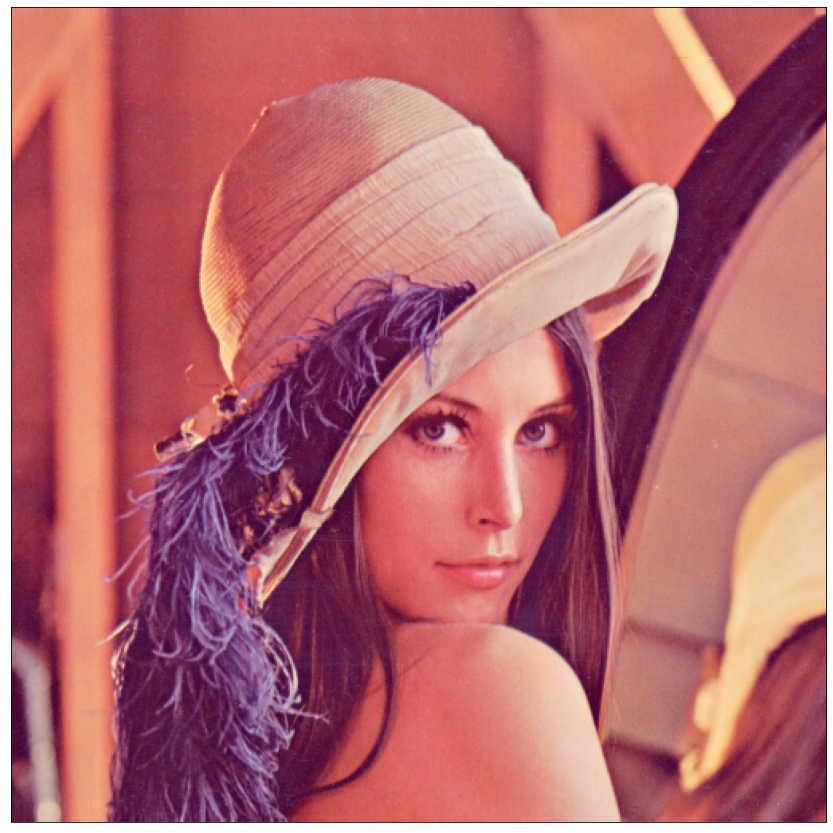

In [4]:
import cv2
img = cv2.imread('lenna.png')
img = img[:, :, [2, 1, 0]]
showImage(img)

In [5]:
height  = len(img) #one column of image
width = len(img[0]) # one row of image
sliced = [] # new list for 8x8 sliced image 

block = 8

npImg = np.array(img);
print(img[:,:,0]);

#print(height)
# print(width)

print("Dimensions of image:")
print(img.shape)
# print(img)


[[226 226 223 ... 230 221 200]
 [226 226 223 ... 230 221 200]
 [226 226 223 ... 230 221 200]
 ...
 [ 84  84  92 ... 173 172 177]
 [ 82  82  96 ... 179 181 185]
 [ 82  82  96 ... 179 181 185]]
Dimensions of image:
(512, 512, 3)


In [6]:
sliced = []
temp = []

#For each z dimension
for k in range(0,3,1):
    temp = []
    index = 0
    currY = 0 #current Y index
    for i in range(block,height+1,block):
        currX = 0 #current X index
        for j in range(block,width+1,block):
            
            #Making blocks of 2x2 from the matrix
            temp.append(img[currY:i, currX:j, k] - np.ones((8,8))*128) #appending blocks to a temporary array
            currX = j
        currY = i        
    sliced.append(temp) #Appending temporary array to final array

In [7]:
dctSliced = []
for k in range(0,3,1):
    temp = []
    for x in sliced[k]:
        dctx = cv2.dct(x)
        y = cv2.idct(dctx)
        #print(x)
        #print("gap")
        #print(dctx)
        temp.append(dctx)
    dctSliced.append(temp)
print(dctSliced[0][0])

[[ 7.82750000e+02 -7.10081609e+00  8.15640312e+00  4.23828243e+00
  -1.75000000e+00 -3.59788316e+00 -1.21370839e+00  2.50910534e+00]
 [-1.50922848e+00  4.24728092e-01  4.74012062e-03  1.89611832e+00
   7.84361541e-01  1.24773589e+00 -3.35816833e+00 -8.67269852e-01]
 [-7.09324174e-01 -7.94963836e-01 -7.37436867e-01 -9.25819434e-01
  -1.35299025e-01 -2.06023709e-01  9.26776695e-01  1.01934611e+00]
 [ 2.68279562e+00  1.03579613e+00  1.36761868e+00  2.07955341e-01
  -4.84709651e-01 -4.63988370e-01  9.54900027e-01 -1.27566589e+00]
 [-3.25000000e+00 -9.24996293e-01 -1.49790468e+00 -2.48824251e-01
   7.50000000e-01  1.86000630e-01 -1.00313587e+00  1.55655778e+00]
 [ 2.39393161e+00  5.25665890e-01  1.12419673e+00  8.46671802e-01
  -6.24545078e-01  7.49151441e-01 -4.25436276e-01 -1.68907761e+00]
 [-1.05917856e+00 -1.17458377e-01 -5.73223305e-01 -1.28424429e+00
   3.26640741e-01 -1.43341641e+00  1.73743687e+00  1.48715034e+00]
 [ 2.09591370e-01 -5.66096804e-02  1.79297087e-01  9.77137842e-01
  -

In [8]:
selectedQMatrix = selectQMatrix("Q90")

quantSliced = []
print(selectedQMatrix)
for k in range(0,3,1):
    temp = []
    for x in dctSliced[k]:
        #print(x)
        x = np.round(x/selectedQMatrix)
        #print("gap")
        #print(x)
        temp.append(x)
        #print(x)
    quantSliced.append(temp)
print(quantSliced[0][0])

[[ 3  2  2  3  5  8 10 12]
 [ 2  2  3  4  5 12 12 11]
 [ 3  3  3  5  8 11 14 11]
 [ 3  3  4  6 10 17 16 12]
 [ 4  4  7 11 14 22 21 15]
 [ 5  7 11 13 16 12 23 18]
 [10 13 16 17 21 24 24 21]
 [14 18 19 20 22 20 20 20]]
[[261.  -4.   4.   1.  -0.  -0.  -0.   0.]
 [ -1.   0.   0.   0.   0.   0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.  -0.  -0.   0.   0.]
 [  1.   0.   0.   0.  -0.  -0.   0.  -0.]
 [ -1.  -0.  -0.  -0.   0.   0.  -0.   0.]
 [  0.   0.   0.   0.  -0.   0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.   0.  -0.   0.   0.]
 [  0.  -0.   0.   0.  -0.   0.  -0.  -0.]]


In [9]:
zigZagSliced = []
temp = []

for k in range(0,3,1):
    temp = []
    for x in quantSliced[k]:
        zList = zigZag(x)
#         print(zList)
        temp.append(zList)
    zigZagSliced.append(temp)
print(zigZagSliced[0][0])

[261.0, -4.0, -1.0, -0.0, 0.0, 4.0, 1.0, 0.0, -0.0, 1.0, -1.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0]


In [10]:
huffSliced = []

temp = []

for k in range(0,3,1):
    temp = []
    huffList = []
    for x in zigZagSliced[k]:
        temp = temp + x
    huffSliced.append(temp)
# print(huffSliced[0][0])

In [11]:
#huffSliced is a list consisting of 3 lists for 3 dimensions. Each list having 4096 elements.
#The 8x8 matrix lists have been merged and appended to each of the above lists.

encodedData = []
compress = HuffmanEncoding()

encodedData = compress.encodeData(huffSliced[0])
print(encodedData)

0111101011010011111101011011111000111001010111111111111111111111111111111111111111111111111111110000110110000000101001010110101011010101011101010101111111111111111111111111111111111111111111111101111001100100111001100100101001010101101011111111111111111111111111111111111111111111111111111000011011101010011100010100110010110010101110011010111111111111111111111111111111111111111111111111110111101011010011110010001101101000101011101011101011111111111111111111111111111111111111111111111111000001100010000011000111111001001011001011010101110101001111110011111111111111111111111111111111111111111111100001100000001000001110101101110011010011111111111010111111110101111111111111111111111111111111111110110000110000011110001100000011101000100010111000000100111001010010010010010111000101011111111110011111111111111111111111111111111111110000111011110000001001110101000010001110110110010011010100101011010100111111110101111111111111111111111111111111111110111100110011101111000100100010100101001101000110

In [12]:
#Padding Encoded Data
padded_encoded_text = compress.padEncodedData(encodedData)

if(len(padded_encoded_text) % 8 != 0):
    print("Encoded text not padded properly")
    
#Converting data into Byte Array
data = bytearray()
for i in range(0, len(padded_encoded_text), 8):
    byte = padded_encoded_text[i:i+8]
    data.append(int(byte, 2))

print(data)


bytearray(b'\x08z\xd3\xf5\xbe9_\xff\xff\xff\xff\xff\xff\r\x80\xa5j\xd5u_\xff\xff\xff\xff\xff\xded\xe6JU\xaf\xff\xff\xff\xff\xff\xff\x86\xeaqL\xb2\xb9\xaf\xff\xff\xff\xff\xff\xfd\xebO#h\xae\xba\xff\xff\xff\xff\xff\xff\xc1\x881\xf9,\xb5u??\xff\xff\xff\xff\xfe\x18\x08:\xdc\xd3\xff\xaf\xf5\xff\xff\xff\xff\xec0x\xc0\xe8\x8b\x819I%\xc5\x7f\xe7\xff\xff\xff\xff\xc3\xbc\t\xd4#\xb6MJ\xd4\xff_\xff\xff\xff\xfe\xf3;\xc4\x8aSF\x91\xff\xf3\xff\xff\xff\xff\xe3Vj-k\x8aD\xd6N\xbf\xaf\xff\xff\xff\xfe\'\x07\x0e\xae\xd6r\xbf\xfa\xff\xff\xff\xff\xf7\x8c\xac\x97\x02d\xfd/\xff\xff\xff\xff\xff\xfb\x0ca\xae\xe2\xa7Z\xff\xff\xff\xff\xff\xff\x87$`\x16\x96\xb3\xae\xae_\xf5\xff\xff\xff\xff\xf1}\xb3%\xa9\xb5\xe9k\xcf3\xff\xff\xff\xff\xbd\xa4R6\xb9\x7f\xaf\xff?\xff\xff\xff\xf8X;L\xa4uuO\xff\xff\xff\xff\xff\xe1\xc8\x1c`\xf6\xdbv\x8b\xa7\xff\xff\xff\xff\xff\xfb\xdaF?*\xd6\xe8\xaf\xff\xcf\xff\xff\xff\xff\xbcn\xa4u;\xa9\xcb\x9f\xff\xff\xff\xff\xffx\xd5Z\x95\x14j\x91\xa3\xf9\xff\xff\xff\xff\xf7\x8d\x8e\xfd\xb6\xa3\xeaQ\xf

In [13]:
memory = FileStorage()
tree = compress.huffmanEncoding(huffSliced[0])

serializedTree = memory.serialize(tree)
print(len(serializedTree))

983


In [14]:
filename =  "ci.bin"
outfile = open(filename,'wb')

#Adding Tree to File
outfile = memory. storeTreeInFile(outfile, serializedTree)

In [15]:
#Adding Data to File 
outfile = memory.storeDataInFile(outfile, data)

In [16]:
memory = FileStorage()
decompress = HuffmanEncoding()

In [17]:
filename =  "ci.bin"

infile = open(filename, "rb")
tree = memory.fetchTreeFromFile(infile)
paddedData = memory.fetchDataFromFile(infile)

encodedData = decompress.unpadEncodedData(paddedData)

memory.index = 0
huffmanTree = memory.deserialize(tree)

In [18]:
origData = []

# ref = copy.deepcopy(tree)
ref = huffmanTree

for bit in encodedData:
    if(bit == '0'):
        ref = ref.left
    else:
        ref = ref.right
    if(ref.value != None):
        origData.append(ref.value)
#         ref = copy.deepcopy(tree)
        ref = huffmanTree

print(origData)

if functools.reduce(lambda i, j : i and j, map(lambda m, k: m == k, origData, huffSliced[0]), True) :  
    print ("The lists are identical") 
else : 

    print ("The lists are not identical") 

[261.0, -4.0, -1.0, -0.0, -0.0, 4.0, 1.0, -0.0, -0.0, 1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 259.0, 5.0, -1.0, -0.0, 2.0, -1.0, -0.0, -0.0, -1.0, -0.0, -1.0, -0.0, -0.0, -0.0, -1.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 253.0, -2.0, -3.0, 1.0, -1.0, -1.0, -0.0, -1.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 

In [61]:
print(len(quantSliced[0]))

4096


In [68]:
m = n = 0
cnt1 = cnt2 = 0
reconSliced = []
compressedImg = np.ones((len(img[:,:,0]),len(img[:,:,0][0])))
for i in range(0, len(origData), block*block):
    temp = reverseZigZag(origData[i:i+64])
    reconSliced.append(temp)

[[261.0, -4.0, 4.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[261.  -4.   4.   1.  -0.  -0.  -0.   0.]
 [ -1.   0.   0.   0.   0.   0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.  -0.  -0.   0.   0.]
 [  1.   0.   0.   0.  -0.  -0.   0.  -0.]
 [ -1.  -0.  -0.  -0.   0.   0.  -0.   0.]
 [  0.   0.   0.   0.  -0.   0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.   0.  -0.   0.   0.]
 [  0.  -0.   0.   0.  -0.   0.  -0.  -0.]]
[[259.0, 5.0, -1.0, -0.0, -1.0, -0.0, -0.0, -0.0], [-1.0, 2.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0,

 [ -0.   0.  -0.   0.  -0.  -0.   0.   0.]]
[[198.0, 6.0, 2.0, 1.0, 1.0, -0.0, -0.0, -0.0], [-4.0, 2.0, 1.0, -0.0, 1.0, -0.0, -0.0, -0.0], [1.0, -3.0, 3.0, -0.0, -1.0, -0.0, -0.0, -0.0], [1.0, 1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[198.   6.   2.   1.   1.  -0.   0.  -0.]
 [ -4.   2.   1.   0.   1.   0.   0.   0.]
 [  1.  -3.   3.   0.  -1.  -0.   0.   0.]
 [  1.   1.  -1.  -0.  -0.   0.  -0.  -0.]
 [ -0.   0.   0.   0.  -0.   0.  -0.  -0.]
 [ -1.   0.   0.   0.  -0.  -0.  -0.  -0.]
 [  0.  -0.   0.  -0.   0.   0.  -0.   0.]
 [ -0.  -0.  -0.  -0.   0.  -0.  -0.  -0.]]
[[199.0, -1.0, -0.0, 2.0, -0.0, -0.0, -0.0, -0.0], [1.0, -1.0, 1.0, -0.0, -0.0, -1.0, -0.0, -0.0], [-0.0, -1.0, 2.0, 1.0, 1.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [2.0, -0.0, -0.0, -0.0, 

 [ -0.   0.  -0.   0.  -0.  -0.  -0.   0.]]
[[204.0, -7.0, -5.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-5.0, -3.0, -1.0, 1.0, 1.0, -0.0, -0.0, -0.0], [-1.0, -0.0, 2.0, -1.0, -0.0, -0.0, 1.0, -0.0], [2.0, -1.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[204.  -7.  -5.   1.   0.   0.  -0.   0.]
 [ -5.  -3.  -1.   1.   1.  -0.   0.   0.]
 [ -1.  -0.   2.  -1.  -0.   0.   1.   0.]
 [  2.  -1.   0.  -1.  -0.   0.   0.   0.]
 [  1.  -0.  -1.  -0.   0.   0.  -0.   0.]
 [ -1.   0.   0.  -1.   0.   0.   0.   0.]
 [ -0.  -1.   0.   0.   1.  -0.   0.  -0.]
 [  0.   0.  -0.   0.   0.  -0.  -0.  -0.]]
[[211.0, -3.0, -0.0, -1.0, -0.0, -0.0, -1.0, -0.0], [6.0, -3.0, -3.0, -0.0, -1.0, -0.0, -0.0, -0.0], [2.0, -2.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, 2.0, -1.0, -2.0, -0.0, -0.0, -0.0, -0.0], [1.0, -1.0, -1.0, 

 [ -0.   0.   0.  -0.   0.   0.  -0.  -0.]]
[[170.0, -5.0, 1.0, -1.0, 1.0, -0.0, -0.0, -0.0], [-6.0, 3.0, -4.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -3.0, -2.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, 1.0, 1.0, -0.0, -0.0, -0.0, -1.0], [-0.0, 2.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[170.  -5.   1.  -1.   1.  -0.   0.  -0.]
 [ -6.   3.  -4.  -0.  -0.  -0.  -0.   0.]
 [ -1.  -3.  -2.   0.   0.   0.   0.   0.]
 [  0.  -1.   1.   1.   0.  -0.   0.  -1.]
 [  0.   2.   1.  -0.  -0.   0.  -0.  -0.]
 [  0.  -0.   0.  -0.   0.   0.   0.   0.]
 [ -0.  -0.   0.  -0.  -0.   0.   0.  -0.]
 [  0.   0.  -0.   0.  -0.   0.   0.  -0.]]
[[182.0, -5.0, -2.0, -1.0, -0.0, -0.0, -1.0, -0.0], [-0.0, -2.0, 1.0, -0.0, -1.0, -0.0, -0.0, 1.0], [2.0, 2.0, 1.0, -1.0, -0.0, -0.0, -0.0, 1.0], [1.0, -1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 1.0, -0.0, -0.0

 [  0.   0.  -0.  -0.   0.   0.   0.  -0.]]
[[275.0, 6.0, -1.0, 1.0, -1.0, 1.0, -0.0, -0.0], [1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, 1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[275.   6.  -1.   1.  -1.   1.  -0.   0.]
 [  1.  -1.  -0.  -0.  -0.  -0.  -0.   0.]
 [  1.   1.  -1.  -0.   0.   0.  -0.   0.]
 [ -1.   0.  -0.   0.  -0.  -0.  -0.   0.]
 [  1.  -1.  -0.  -0.  -0.  -0.  -0.  -0.]
 [ -1.   0.  -0.   0.   0.  -0.  -0.  -0.]
 [ -0.  -0.   0.  -0.   0.  -0.  -0.  -0.]
 [  0.  -0.  -0.  -0.   0.   0.   0.   0.]]
[[199.0, 69.0, -14.0, 4.0, -0.0, 1.0, -0.0, -0.0], [-0.0, 4.0, -1.0, -1.0, 1.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -2.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -2.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -1.0,

 [ -0.  -0.  -0.   0.  -0.   0.  -0.  -0.]]
[[165.0, -10.0, -6.0, -1.0, 2.0, -0.0, -0.0, -0.0], [13.0, 9.0, 5.0, 2.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, 1.0, -3.0, -1.0, -0.0, -0.0, -0.0], [-0.0, -0.0, 1.0, 2.0, -0.0, -0.0, -0.0, -0.0], [3.0, -1.0, 2.0, -2.0, -0.0, -0.0, -0.0, -0.0], [-2.0, 1.0, -1.0, -0.0, 1.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[165. -10.  -6.  -1.   2.   0.   0.   0.]
 [ 13.   9.   5.   2.  -0.  -0.   0.   0.]
 [ -0.  -0.   1.  -3.  -1.  -0.   0.   0.]
 [ -0.   0.   1.   2.  -0.  -0.  -0.  -0.]
 [  3.  -1.   2.  -2.  -0.   0.   0.   0.]
 [ -2.   1.  -1.  -0.   1.  -0.  -0.  -0.]
 [ -0.   0.  -0.   1.  -0.   0.   0.  -0.]
 [  0.  -0.  -0.  -0.  -0.  -0.   0.   0.]]
[[184.0, -13.0, 3.0, -1.0, -1.0, 1.0, -0.0, -0.0], [-17.0, -3.0, 1.0, 1.0, 3.0, -0.0, -0.0, -0.0], [4.0, 7.0, -2.0, -0.0, -0.0, 1.0, -0.0, -0.0], [3.0, -3.0, -6.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -1.0, 2.0, -

 [  0.  -0.  -0.   0.   0.   0.  -0.  -0.]]
[[241.0, 6.0, -3.0, -1.0, -0.0, -0.0, -0.0, -0.0], [1.0, 6.0, -0.0, 2.0, -0.0, -0.0, -0.0, -0.0], [2.0, 1.0, -4.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -2.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[241.   6.  -3.  -1.  -0.  -0.  -0.  -0.]
 [  1.   6.  -0.   2.   0.  -0.  -0.   0.]
 [  2.   1.  -4.   0.   0.  -0.   0.  -0.]
 [ -1.  -2.   0.   0.  -0.  -0.  -0.  -0.]
 [ -1.   0.   0.   0.  -0.   0.   0.  -0.]
 [ -0.   1.   1.  -0.  -0.  -0.  -0.  -0.]
 [  0.  -0.   0.  -0.  -0.   0.   0.   0.]
 [  0.   0.  -0.  -0.   0.  -0.  -0.  -0.]]
[[237.0, -2.0, -3.0, -0.0, 1.0, -0.0, -0.0, -0.0], [1.0, -7.0, -1.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-4.0, -2.0, -2.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-2.0, -1.0, -0.0, 

 [  0.  -0.  -0.   0.  -0.   0.  -0.  -0.]]
[[250.0, 36.0, -12.0, 4.0, -2.0, -0.0, -0.0, -0.0], [13.0, -9.0, -8.0, 3.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -3.0, 5.0, 2.0, -2.0, 1.0, -0.0, -0.0], [2.0, -2.0, 2.0, -3.0, 1.0, -0.0, -0.0, -0.0], [-1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[250.  36. -12.   4.  -2.  -0.  -0.  -0.]
 [ 13.  -9.  -8.   3.  -0.  -0.  -0.   0.]
 [ -1.  -3.   5.   2.  -2.   1.  -0.   0.]
 [  2.  -2.   2.  -3.   1.   0.  -0.   0.]
 [ -1.   1.  -0.   0.   0.  -0.   0.   0.]
 [ -0.   0.   0.   0.  -0.   0.  -0.   0.]
 [ -0.  -0.   0.   0.  -0.  -0.  -0.  -0.]
 [  0.  -0.  -0.   0.   0.  -0.   0.  -0.]]
[[156.0, 39.0, -3.0, -3.0, -0.0, -0.0, -0.0, -0.0], [72.0, -29.0, -12.0, -0.0, -1.0, -0.0, -0.0, -0.0], [-17.0, -9.0, 8.0, -0.0, 1.0, -0.0, -0.0, -0.0], [-0.0, 13.0, -6.0, 1.0, -0.0, -0.0, -0.0, -0.0], [1.0, -3.0, -0.

 [  0.  -0.   0.   0.   0.  -0.  -0.  -0.]]
[[-33.0, -52.0, -39.0, 22.0, -8.0, 2.0, -1.0, -0.0], [-17.0, -16.0, 33.0, -3.0, 1.0, 1.0, -0.0, 1.0], [-2.0, 9.0, 8.0, -6.0, 2.0, -1.0, 1.0, -1.0], [5.0, 6.0, 1.0, -3.0, -0.0, -0.0, -1.0, -0.0], [-1.0, 1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, 1.0, -0.0, -0.0, -0.0, -1.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[-33. -52. -39.  22.  -8.   2.  -1.  -0.]
 [-17. -16.  33.  -3.   1.   1.   0.   1.]
 [ -2.   9.   8.  -6.   2.  -1.   1.  -1.]
 [  5.   6.   1.  -3.  -0.   0.  -1.  -0.]
 [ -1.   1.  -1.  -0.   0.   0.   0.   0.]
 [ -1.   1.   0.   0.  -0.  -1.  -0.  -0.]
 [ -1.  -0.  -0.   0.  -0.  -0.  -0.   0.]
 [ -0.   0.  -1.  -0.   0.   0.   0.   0.]]
[[-98.0, -32.0, 23.0, -8.0, 6.0, -2.0, 1.0, -0.0], [-8.0, 14.0, 7.0, 1.0, 1.0, -0.0, 1.0, 1.0], [3.0, 5.0, -2.0, 3.0, -0.0, 1.0, -0.0, -0.0], [-0.0, 4.0, 3.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -1.0, 1.0, -0.0,

 [  0.   0.  -0.  -0.   0.  -0.   0.   0.]]
[[168.0, 7.0, 2.0, -1.0, -0.0, 1.0, -0.0, -0.0], [-10.0, 16.0, -4.0, -1.0, -1.0, -0.0, -0.0, -0.0], [4.0, -12.0, 7.0, 2.0, -1.0, -0.0, -0.0, -0.0], [1.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[168.   7.   2.  -1.  -0.   1.   0.  -0.]
 [-10.  16.  -4.  -1.  -1.   0.  -0.   0.]
 [  4. -12.   7.   2.  -1.   0.  -0.  -0.]
 [  1.   0.   0.  -1.   0.   0.   0.   0.]
 [ -1.   1.  -0.  -0.  -0.   0.   0.   0.]
 [ -1.  -0.   0.  -0.  -0.   0.   0.   0.]
 [ -0.   0.  -0.   0.  -0.  -0.  -0.   0.]
 [ -0.   0.   0.   0.  -0.  -0.  -0.  -0.]]
[[186.0, -24.0, -6.0, 4.0, -0.0, 1.0, -0.0, -0.0], [-13.0, -18.0, -7.0, 3.0, 1.0, -0.0, -0.0, 1.0], [-3.0, -4.0, 7.0, 3.0, -0.0, -0.0, -0.0, -0.0], [-1.0, 1.0, 3.0, 2.0, -0.0, -0.0, -0.0, -0.0], [1.0, 2.0, -0.0, -1.

 [  0.  -0.  -0.  -0.   0.   0.  -0.  -0.]]
[[119.0, 17.0, 23.0, -2.0, 4.0, -1.0, -1.0, -1.0], [23.0, 30.0, -4.0, -0.0, -3.0, -0.0, 1.0, -0.0], [28.0, 16.0, 1.0, 2.0, -0.0, 1.0, -0.0, -0.0], [40.0, -8.0, -7.0, 1.0, -1.0, -0.0, 1.0, -0.0], [-4.0, -4.0, -1.0, -0.0, -0.0, -0.0, -0.0, -1.0], [3.0, -1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[119.  17.  23.  -2.   4.  -1.  -1.  -1.]
 [ 23.  30.  -4.  -0.  -3.   0.   1.  -0.]
 [ 28.  16.   1.   2.   0.   1.  -0.   0.]
 [ 40.  -8.  -7.   1.  -1.  -0.   1.  -0.]
 [ -4.  -4.  -1.  -0.  -0.   0.  -0.  -1.]
 [  3.  -1.  -1.  -0.   0.  -0.  -0.   0.]
 [ -1.  -0.   0.   0.   0.   0.  -0.   0.]
 [  0.   0.  -0.  -0.   0.   0.  -0.   0.]]
[[89.0, 47.0, 2.0, 7.0, -5.0, -0.0, -0.0, 1.0], [-35.0, -1.0, -0.0, -1.0, 1.0, 1.0, -0.0, -0.0], [-42.0, 8.0, 9.0, -1.0, -0.0, -1.0, -0.0, -0.0], [14.0, 19.0, 1.0, -0.0, 1.0, -0.0, -0.0, -0.0], [2.0, -0.0, -0.0, -0.0,

 [  0.  -0.   0.   0.  -0.  -0.  -0.   0.]]
[[196.0, -29.0, -4.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-8.0, -1.0, 4.0, 1.0, -1.0, -0.0, -0.0, -0.0], [3.0, 1.0, 2.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, 1.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[196. -29.  -4.   1.   0.   0.   0.   0.]
 [ -8.  -1.   4.   1.  -1.   0.   0.   0.]
 [  3.   1.   2.  -0.   0.  -0.  -0.  -0.]
 [  1.   1.   0.   1.  -0.  -0.  -0.  -0.]
 [  0.   1.   1.   0.  -0.  -0.  -0.   0.]
 [ -1.  -1.  -0.  -0.  -0.  -0.  -0.  -0.]
 [  0.   0.   0.   0.   0.  -0.   0.   0.]
 [ -0.   0.   0.   0.   0.   0.  -0.   0.]]
[[212.0, -0.0, -2.0, 2.0, -0.0, -0.0, -0.0, -0.0], [2.0, -0.0, -1.0, 1.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -0.0, -0.0,

 [ -0.  -0.   0.   0.   0.  -0.  -0.   0.]]
[[288.0, -12.0, -5.0, -2.0, -0.0, -0.0, -0.0, -0.0], [-10.0, -8.0, -1.0, -1.0, -1.0, -0.0, -0.0, -0.0], [-2.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[288. -12.  -5.  -2.   0.   0.  -0.  -0.]
 [-10.  -8.  -1.  -1.  -1.   0.   0.   0.]
 [ -2.  -1.   0.  -0.   0.   0.   0.   0.]
 [ -1.  -0.  -0.   0.  -0.   0.  -0.  -0.]
 [ -1.  -1.  -0.   0.  -0.   0.   0.   0.]
 [  0.   0.   0.  -0.  -0.   0.   0.  -0.]
 [ -0.   0.  -0.  -0.  -0.   0.   0.  -0.]
 [ -0.   0.  -0.  -0.   0.  -0.  -0.  -0.]]
[[291.0, 1.0, -1.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -

[[251.0, -6.0, -2.0, -1.0, -1.0, -0.0, -0.0, -0.0], [-0.0, 2.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, 1.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 1.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[251.  -6.  -2.  -1.  -1.  -0.   0.   0.]
 [ -0.   2.   0.  -0.  -0.   0.  -0.   0.]
 [  1.   1.  -0.   1.  -0.   0.   0.   0.]
 [  0.   1.  -0.  -1.  -0.  -0.  -0.  -0.]
 [  0.  -1.   0.  -0.  -0.  -0.   0.   0.]
 [  1.  -0.  -0.   0.   0.   0.   0.   0.]
 [  0.  -0.   0.   0.  -0.  -0.  -0.  -0.]
 [ -0.   0.  -0.   0.  -0.   0.  -0.  -0.]]
[[260.0, 2.0, -2.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, 1.0, -0.0, -1.0, -0.0, -0.0, -0.0], [-0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -

[[190.0, 85.0, -67.0, 4.0, -2.0, 2.0, -1.0, -0.0], [65.0, -132.0, 5.0, 8.0, -6.0, -0.0, -1.0, 1.0], [-27.0, -4.0, 19.0, -13.0, 2.0, 1.0, -0.0, 1.0], [1.0, 3.0, -8.0, 4.0, 2.0, -1.0, -0.0, 1.0], [-5.0, -0.0, 3.0, -0.0, -2.0, -0.0, -0.0, -0.0], [-2.0, -0.0, -1.0, -0.0, -0.0, -0.0, 1.0, 1.0], [-0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[ 190.   85.  -67.    4.   -2.    2.   -1.   -0.]
 [  65. -132.    5.    8.   -6.   -0.   -1.    1.]
 [ -27.   -4.   19.  -13.    2.    1.    0.    1.]
 [   1.    3.   -8.    4.    2.   -1.   -0.    1.]
 [  -5.    0.    3.   -0.   -2.   -0.   -0.   -0.]
 [  -2.   -0.   -1.   -0.    0.   -0.    1.    1.]
 [  -0.   -0.    1.   -0.    0.    0.    0.   -0.]
 [   0.   -0.   -0.    0.    0.    0.   -0.   -0.]]
[[-85.0, 30.0, 26.0, 14.0, 4.0, -0.0, -0.0, -0.0], [29.0, 43.0, 22.0, 11.0, 4.0, -0.0, -0.0, -1.0], [12.0, 15.0, 10.0, 2.0, -0.0, -0.0, -1.0, -1.0], [2.0, 4.0, 3.0, -1.0, -1.0, -0.0, -1.0, -0.0], [1.0,

 [  0.  -0.  -0.   0.   0.  -0.   0.   0.]]
[[141.0, 2.0, -1.0, -3.0, 2.0, -0.0, -0.0, -0.0], [27.0, -0.0, -0.0, -1.0, -1.0, -0.0, -0.0, -0.0], [-0.0, 1.0, 3.0, 1.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-2.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[141.   2.  -1.  -3.   2.   0.   0.  -0.]
 [ 27.  -0.  -0.  -1.  -1.  -0.  -0.  -0.]
 [ -0.   1.   3.   1.  -0.  -0.   0.   0.]
 [  1.  -0.  -1.   0.   0.  -0.   0.   0.]
 [ -2.   1.  -0.  -0.  -0.   0.   0.  -0.]
 [  1.   0.  -0.   0.   0.  -0.   0.   0.]
 [  0.  -0.   0.   0.   0.   0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.  -0.   0.   0.  -0.]]
[[152.0, -6.0, -1.0, -2.0, -0.0, -0.0, -0.0, -0.0], [31.0, 1.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-6.0, 1.0, -2.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0], [-1.0, -1.0, -1.0, -0.

 [ -0.  -0.   0.   0.   0.  -0.  -0.  -0.]]
[[267.0, -3.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [3.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[267.  -3.  -1.  -0.  -0.   0.   0.   0.]
 [  3.  -1.   0.  -0.  -0.   0.  -0.  -0.]
 [ -1.  -0.   1.  -0.   0.   0.   0.   0.]
 [ -0.   0.  -0.  -0.   0.   0.  -0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  -0.]
 [  0.  -0.   0.  -0.   0.  -0.   0.   0.]
 [  0.  -0.   0.   0.  -0.  -0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.  -0.   0.  -0.  -0.]]
[[275.0, -4.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0], [1.0, 2.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0,

 [  0.   0.  -0.  -0.   0.   0.   0.   0.]]
[[140.0, 20.0, -11.0, 3.0, -1.0, -0.0, -0.0, -0.0], [15.0, -13.0, -1.0, -1.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, 5.0, 1.0, -0.0, -1.0, -0.0, -0.0], [-2.0, -1.0, 1.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[140.  20. -11.   3.  -1.   0.   0.   0.]
 [ 15. -13.  -1.  -1.  -0.  -0.  -0.   0.]
 [  1.   0.   5.   1.  -0.  -1.  -0.   0.]
 [ -2.  -1.   1.  -1.   0.   0.   0.  -0.]
 [ -1.   0.   0.   0.  -0.   0.  -0.   0.]
 [ -1.  -0.   0.  -0.   0.  -0.   0.  -0.]
 [  0.  -0.  -0.   0.  -0.   0.   0.  -0.]
 [  0.   0.   0.  -0.   0.   0.  -0.   0.]]
[[80.0, -1.0, 12.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-5.0, 9.0, 2.0, 1.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 2.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0], [1.0, -1.0, -0.0, 

[[156.0, 92.0, -9.0, -0.0, 1.0, 2.0, -1.0, 1.0], [32.0, -40.0, -21.0, -1.0, -0.0, -0.0, -0.0, 1.0], [-7.0, -5.0, 5.0, -1.0, -1.0, -0.0, -0.0, -1.0], [-0.0, -2.0, -2.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[156.  92.  -9.   0.   1.   2.  -1.   1.]
 [ 32. -40. -21.  -1.  -0.  -0.   0.   1.]
 [ -7.  -5.   5.  -1.  -1.  -0.  -0.  -1.]
 [  0.  -2.  -2.  -1.  -0.   0.  -0.  -0.]
 [ -0.  -1.   1.  -0.  -0.   0.  -0.   0.]
 [  1.  -1.  -0.   0.   0.  -0.   0.  -0.]
 [  0.  -0.  -0.   0.  -0.   0.  -0.   0.]
 [ -0.  -0.   0.   0.  -0.   0.  -0.  -0.]]
[[63.0, -15.0, -8.0, -7.0, 1.0, 2.0, -0.0, -0.0], [52.0, -2.0, 2.0, 3.0, -1.0, -0.0, -0.0, -0.0], [2.0, -0.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0], [4.0, -1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, 

 [  0.  -0.  -0.  -0.  -0.   0.   0.   0.]]
[[250.0, 1.0, -0.0, 1.0, 1.0, -0.0, -0.0, 1.0], [-2.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[250.   1.  -0.   1.   1.  -0.   0.   1.]
 [ -2.   1.   0.   0.   0.   0.  -0.   0.]
 [  0.   0.  -1.   0.   0.  -0.   0.   0.]
 [  0.  -1.  -0.   0.   0.   0.   0.   0.]
 [  0.  -1.   0.   0.   0.  -0.   0.  -0.]
 [ -0.   0.   0.  -0.   0.   0.   0.   0.]
 [ -0.  -0.   0.  -0.   0.  -0.  -0.  -0.]
 [ -0.  -0.   0.  -0.   0.   0.   0.   0.]]
[[253.0, -1.0, 1.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 2.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0

 [  0.   0.   0.  -0.  -0.  -0.   0.  -0.]]
[[204.0, -10.0, -5.0, 1.0, -1.0, -0.0, -0.0, -0.0], [-29.0, -6.0, 6.0, -1.0, -0.0, -0.0, -0.0, -0.0], [-7.0, 1.0, 1.0, -1.0, 1.0, -0.0, -0.0, -0.0], [-3.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[204. -10.  -5.   1.  -1.   0.  -0.  -0.]
 [-29.  -6.   6.  -1.  -0.   0.  -0.  -0.]
 [ -7.   1.   1.  -1.   1.   0.   0.  -0.]
 [ -3.   1.   1.  -0.   0.  -0.  -0.   0.]
 [ -1.  -0.   0.  -0.   0.   0.  -0.  -0.]
 [  1.   0.  -0.  -0.   0.   0.  -0.  -0.]
 [  0.   0.  -0.   0.   0.  -0.  -0.   0.]
 [  0.   0.  -0.   0.  -0.   0.   0.  -0.]]
[[148.0, 61.0, -6.0, 4.0, -1.0, -0.0, -0.0, -0.0], [17.0, -11.0, -3.0, 1.0, -0.0, -0.0, -0.0, -0.0], [-3.0, -1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [1.0, -3.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0

In [43]:
print(quantSliced[0][1])
temp = reverseZigZag(origData[64:128])
print(temp)
print(temp == quantSliced[0][1])

[[259.   5.  -1.   0.  -1.   0.   0.   0.]
 [ -1.   2.  -0.   0.  -1.   0.   0.  -0.]
 [  0.  -1.  -0.   0.   0.  -0.  -0.  -0.]
 [  0.   0.   0.  -0.  -0.  -0.  -0.   0.]
 [ -1.  -0.   0.   0.  -0.   0.   0.  -0.]
 [  0.   0.  -0.  -0.   0.   0.  -0.   0.]
 [ -0.  -0.   0.  -0.  -0.  -0.   0.  -0.]
 [  0.   0.  -0.   0.   0.   0.   0.   0.]]
[[259.0, 5.0, -1.0, -0.0, -1.0, -0.0, -0.0, -0.0], [-1.0, 2.0, -0.0, -0.0, -1.0, -0.0, -0.0, -0.0], [-0.0, -1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]]
[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]


In [19]:

compressedImg = np.ones((len(img[:,:,0]),len(img[:,:,0][0])))
index = 0
currY = 0 #current Y index
for i in range(block,height+1,block):
    currX = 0 #current X index
    for j in range(block,width+1,block):
        compressedImg[currY:i, currX:j] = reverseZigZag(origData[index:index+64])
        index = index+64
        currX = j
    currY = i

print(len(quantSliced[0]))
print("END!!!")
print(len(compressedImg))

if functools.reduce(lambda i, j : i and j, map(lambda m, k: m == k, quantSliced[0], compressedImg), True) :  
    print ("The lists are identical") 
else : 

    print ("The lists are not identical") 

4096
END!!!
512
The lists are not identical


/home/manav/Manav/Academics/Sem6/ML/ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


In [20]:
# import functools
# infile = open(filename, "rb")
# out = []
# last_pos = 0
# byte = infile.read(1)
# if byte == b'#':
#     out.append(byte.decode('utf8'))
# else:
#     infile.seek(last_pos)
#     byte = infile.read(4)
#     byte = struct.unpack('f', byte)
#     out.append(byte)
    
# while True:
    
#     last_pos = infile.tell()
#     byte = infile.read(1)
    
#     if byte == b'*':
#         break
#     elif byte == b'#':
#         out.append(byte.decode('utf8'))        
#     else:
# #         print(len(out))
# # Need to store tree size as well.....
#         if len(out) == len(serializedTree):
#             break
#         infile.seek(last_pos)
#         byte = infile.read(4)
#         byte = struct.unpack('f', byte)
#         out.append(byte)
        
# print(out)


# # if functools.reduce(lambda i, j : i and j, map(lambda m, k: m == k, out, serializedTree), True) :  
# #     print ("The lists are identical") 
# # else : 
# #     print ("The lists are not identical") 

In [21]:
# bitString = ""
# byte = infile.read(1)
# while(byte != b''):
#     byte = ord(byte)
#     bits = bin(byte)[2:].rjust(8, '0')
#     bitString += bits
#     byte = infile.read(1)
    
# print(bitString)

# if functools.reduce(lambda i, j : i and j, map(lambda m, k: m == k, bitString, padded_encoded_text), True) :  
#     print ("The lists are identical") 
# else : 
#     print ("The lists are not identical") 

In [22]:
# infile = open(filename, 'rb')

# inTree = []

# byte = infile.read(1)
# byte = byte.decode('utf8')
# inTree.append(byte)
# while(byte != '*'):
#     byte = infile.read(1)
#     byte = byte.decode('utf8')
#     inTree.append(byte)

# print(inTree)

In [23]:

# bitString = ""
# byte = infile.read(1)
# while(byte != b''):
#     byte = ord(byte)
#     bits = bin(byte)[2:].rjust(8, '0')
#     bitString += bits
#     byte = infile.read(1)
    
# print(bitString)

In [24]:
# bitString = padded_encoded_text

# padded_info = padded_encoded_text[:8]
# extra_padding = int(padded_info, 2)

# padded_encoded_text = padded_encoded_text[8:] 
# encoded_text = padded_encoded_text[:-1*extra_padding]

# print(encoded_text)

In [25]:
# import functools

# #Need to store tree in the file as well
# tree = compress.huffmanEncoding(huffSliced[0])

# origData = []

# ref = tree


# for bit in encoded_text:
#     if(bit == '0'):
#         ref = ref.left
#     else:
#         ref = ref.right
#     if(ref.value != None):
#         origData.append(ref.value)
#         ref = tree

# # print(origData)


# if functools.reduce(lambda i, j : i and j, map(lambda m, k: m == k, huffSliced[0], origData), True) :  
#     print ("The lists are identical") 
# else : 
#     print ("The lists are not identical") 

In [26]:
#Storing files, not succedded yet

#Store files in this cell

#huffSlice is a list consisting of 3 lists(for 3 dimensions) and each list has 4096(number subjective to image dimensions) elements 
#Each of these 4096 elements in all the 3 lists are itself lists having another list of symbols and dictionary
#Try storing these...

# filename = '/home/rushil/Documents/Academics/Image Processing/Image Processing/ci'
# outfile = open(filename,'w')

# for k in range(0,3,1):
#     temp = []
#     temp = huffSliced[k]
#     print(len(temp))
#     for i in temp:
#         huffList = i
#         print(huffList[0])
#         str = ""
#         for j in huffList[0]:
# #             print(type(j))
#             str = str + j
#         print(str)
#         outfile.write(str)
            
# outfile.close()     








# import json


# filename = '/home/rushil/Documents/Academics/Image Processing/Image Processing/ci'
# outfile = open(filename,'w')
# json.dump(huffSliced,outfile)
# outfile.close()


In [27]:

#Of no use....

# npCompImg =np.zeros((len(img[:,:,0]),len(img[:,:,0][0]), 3) )


# for k in range(0,3,1):
#     compressedImg = np.ones((len(img[:,:,0]),len(img[:,:,0][0])))
    
#     index = 0
#     currY = 0 #current Y index
#     for i in range(block,height+1,block):
#         currX = 0 #current X index
#         for j in range(block,width+1,block):
#             compressedImg[currY:i, currX:j] = quantSliced[k][index]
#             index = index+1
#             currX = j
#         currY = i
#     npCompImg[:,:,k] = compressedImg

# print(npCompImg[0][0])




# print("Compressed")
# showImage(npCompImg)







# # cv2.imwrite('/home/rushil/Documents/Academics/Image Processing/Image Processing/compressedlenna.png',npCompImg)

# # print("Original")
# # showImage(img)

# import pickle


# filename = '/home/rushil/Documents/Academics/Image Processing/Image Processing/ci'
# outfile = open(filename,'wb')
# pickle.dump(npCompImg,outfile)
# outfile.close()





In [28]:

#Of no use as of right now ....just store files for time being.....
# for k in range(0,3,1):
#     index = 0
#     currY = 0 #current Y index
#     for i in range(block,height+1,block):
#         currX = 0 #current X index
#         for j in range(block,width+1,block):
#             tempMat = npCompImg[currY:i, currX:j,k]
#             print(tempMat)
#             index = index+1
#             currX = j
#         currY = i

